Problem description:

A delivery company operates a single truck that delivers packages to various locations in a city. The company wants to minimize the total cost of the delivery route, which includes the distance traveled, the fuel consumption, and the carbon emissions. The company also wants to promote sustainability and reduce its environmental impact.

The truck has a fixed capacity of 100 packages, and each location has a demand of 1 to 10 packages. The truck starts and ends its route at the depot, which is located at the center of the city. The locations are randomly distributed within a 10 km by 10 km area.

The distance between any two locations is calculated using the Euclidean formula. The fuel consumption and the carbon emission depend on the distance, the speed, the road conditions, and the truck characteristics. For simplicity, we assume that the fuel consumption is proportional to the distance, and the carbon emission is proportional to the fuel consumption.

The company wants to find the optimal route for the truck that visits all the locations exactly once and returns to the depot, while satisfying the capacity and demand constraints, and minimizing the total cost.

Mathematical model:

Let n be the number of locations, including the depot. Let d[i][j] be the distance between location i and location j, for i, j = 0, ..., n-1. Let f[i][j] be the fuel consumption when traveling from location i to location j, for i, j = 0, ..., n-1. Let c[i][j] be the carbon emission when traveling from location i to location j, for i, j = 0, ..., n-1. Let w1, w2, and w3 be the weights for the distance, the fuel consumption, and the carbon emission, respectively. Let q[i] be the demand of location i, for i = 0, ..., n-1. Let Q be the capacity of the truck.

The decision variables are:

- x[i][j]: a binary variable that indicates whether the truck travels from location i to location j, for i, j = 0, ..., n-1.
- y[i]: a continuous variable that indicates the position of location i in the route, for i = 0, ..., n-1.

The objective function is:

$$\min \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} (w_1 d_{ij} + w_2 f_{ij} + w_3 c_{ij}) x_{ij}$$

The constraints are:

- Flow conservation: for each location i, the truck can enter and leave at most once.

$$\sum_{j=0}^{n-1} x_{ij} = 1, \quad \forall i = 0, ..., n-1$$
$$\sum_{i=0}^{n-1} x_{ij} = 1, \quad \forall j = 0, ..., n-1$$

- Subtour elimination: for each pair of locations i and j, the position of location i in the route must be smaller than the position of location j if the truck travels from i to j.

$$y_i + 1 \leq y_j + n (1 - x_{ij}), \quad \forall i, j = 1, ..., n-1, i \neq j$$

- Depot constraints: the position of the depot in the route must be 0.

$$y_0 = 0$$

- Capacity and demand constraints: the total demand of the locations visited by the truck must not exceed the capacity of the truck.

$$\sum_{i=0}^{n-1} \sum_{j=0}^{n-1} q_j x_{ij} \leq Q$$


In [ ]:
!pip3 install ortools

In [ ]:
# Import the libraries
from ortools.constraint_solver import pywrapcp
from ortools.linear_solver import pywraplp
import numpy as np
import math

# Define the data

# Number of locations, including depot
num_locations = 10
# Depot location
depot = 0
# Number of vehicles
num_vehicles = 1
# Capacity of the truck
capacity = 100
# Demands of the locations
demands = np.random.randint(1, 11, size=num_locations)
# Depot has no demand
demands[depot] = 0
# Size of the area
area_size = 10
# Coordinates of the locations
locations = np.random.uniform(0, area_size, size=(num_locations, 2))
# Distance matrix
distance_matrix = np.zeros((num_locations, num_locations))
# Fuel consumption matrix
fuel_matrix = np.zeros((num_locations, num_locations))
# Carbon emission matrix
carbon_matrix = np.zeros((num_locations, num_locations))
# Weight for the distance
distance_weight = 1
# Weight for the fuel consumption
fuel_weight = 2
# Weight for the carbon emission
carbon_weight = 3
# Factor for the fuel consumption
fuel_factor = 0.1
# Factor for the carbon emission
carbon_factor = 2.4

# Calculate the distance, the fuel consumption, and the carbon emission matrices
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            distance_matrix[i][j] = math.sqrt((locations[i][0] - locations[j][0])**2 + (locations[i][1] - locations[j][1])**2)
            fuel_matrix[i][j] = distance_matrix[i][j] * fuel_factor
            carbon_matrix[i][j] = fuel_matrix[i][j] * carbon_factor

# Create the routing model
manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)
routing = pywrapcp.RoutingModel(manager)

# Define the cost function
def cost_function(from_index, to_index):
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(distance_weight * distance_matrix[from_node][to_node] + fuel_weight * fuel_matrix[from_node][to_node] + carbon_weight * carbon_matrix[from_node][to_node])

# Set the arc cost evaluator
transit_callback_index = routing.RegisterTransitCallback(cost_function)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add the capacity and demand constraints
def demand_callback(from_index):
    # Returns the demand of the node.
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return demands[from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    [capacity],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# Set the search parameters
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(1)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

# Print the solution
if solution:
    print('Total cost = {}'.format(solution.ObjectiveValue()))
    print('Route for vehicle 0:')
    index = routing.Start(0)
    route_distance = 0
    route_fuel = 0
    route_carbon = 0
    while not routing.IsEnd(index):
        node = manager.IndexToNode(index)
        next_node = manager.IndexToNode(solution.Value(routing.NextVar(index)))
        route_distance += distance_matrix[node][next_node]
        route_fuel += fuel_matrix[node][next_node]
        route_carbon += carbon_matrix[node][next_node]
        print('{} -> '.format(node), end='')
        index = solution.Value(routing.NextVar(index))
    node = manager.IndexToNode(index)
    print(node)
    print('Route distance = {}'.format(route_distance))
    print('Route fuel consumption = {}'.format(route_fuel))
    print('Route carbon emission = {}'.format(route_carbon))
else:
    print('No solution found')


Total cost = 53
Route for vehicle 0:
0 -> 2 -> 3 -> 8 -> 1 -> 9 -> 5 -> 6 -> 7 -> 4 -> 0
Route distance = 29.065564108790667
Route fuel consumption = 2.906556410879067
Route carbon emission = 6.97573538610976


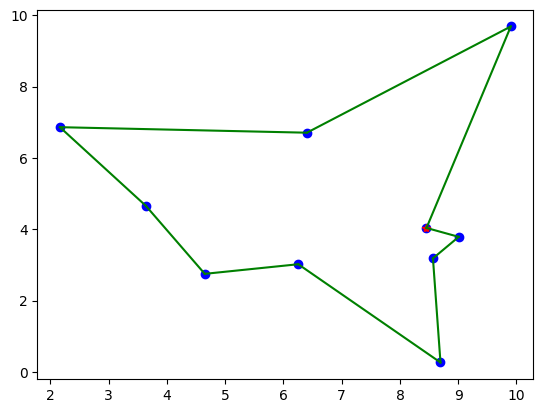

In [ ]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot the locations
plt.scatter(locations[:, 0], locations[:, 1], c='b')
# Plot the depot
plt.plot(locations[depot, 0], locations[depot, 1], c='r', marker='*')
# Plot the route
index = routing.Start(0)
while not routing.IsEnd(index):
    node = manager.IndexToNode(index)
    next_node = manager.IndexToNode(solution.Value(routing.NextVar(index)))
    # Draw a line from node to next_node
    plt.plot([locations[node, 0], locations[next_node, 0]], [locations[node, 1], locations[next_node, 1]], c='g')
    index = solution.Value(routing.NextVar(index))
# Show the plot
plt.show()
